# Two-Way Tables and Two Categorical Variables

Data science is all about relationships between variables. How do we summarize and visualize the relationship between two categorical variables?

For example, what can we say about the relationship between gender and survival on the Titanic?

In [3]:
import pandas as pd
data_dir = "http://dlsun.github.io/pods/data/"
df_titanic = pd.read_csv(data_dir + "titanic.csv")

We can summarize each variable individually like we did in the previous lesson.

In [ ]:
df_titanic["gender"].value_counts()

male      1718
female     489
Name: gender, dtype: int64

In [ ]:
df_titanic["survived"].value_counts()

0    1496
1     711
Name: survived, dtype: int64

But this does not tell us how gender interacts with survival. To do that, we need to produce a _cross-tabulation_, or "cross-tab" for short. (Statisticians tend to call this a _contigency table_ or a _two-way table_.)

In [ ]:
pd.crosstab(df_titanic["survived"], df_titanic["gender"])

gender,female,male
survived,,
0,130,1366
1,359,352


A cross-tabulation of two categorical variables is a two-dimensional array, with the levels of one variable along the rows and the levels of the other variable along the columns. Each cell in this array contains the number of observations that had a particular combination of levels. So in the Titanic data set, there were 359 females who survived and 1366 males who died. From the cross-tabulation, we can see that there were more females who survived than not, while there were more males who died than not. Clearly, gender had a strong influence on survival because of the Titanic's policy of ["women and children first"](https://en.wikipedia.org/wiki/Women_and_children_first).

To get probabilities instead of counts, we specify `normalize=True`.


In [ ]:
joint_survived_gender = pd.crosstab(df_titanic["survived"], df_titanic["gender"], 
                                    normalize=True)
joint_survived_gender

gender,female,male
survived,,
0,0.058903,0.618940
1,0.162664,0.159493


Notice that the four probabilities in this table add up to 1.0. Each of these probabilities is called a joint probability and can be notated, for example, as 

$$ P(\text{female}, \text{died}) = 0.058903.$$

Collectively, these probabilities make up the _joint distribution_ of the variables **survived** and **gender**.

## Marginal Distributions

Is it possible to recover the distribution of **gender** alone from the joint distribution of **survived** and **gender**? 

Yes! We simply sum the probabilities for each **gender** over all the possible levels of **survived**.

\begin{align}
P(\text{female}) = P(\text{female}, \text{died}) + P(\text{female}, \text{survived}) &= 0.058903 + 0.162664 = 0.221567 \\
P(\text{male}) = P(\text{male}, \text{died}) + P(\text{male}, \text{survived}) &= 0.618940 + 0.159493 = 0.778433
\end{align}

In code, this can be achieved by summing the `DataFrame` _over_ one of the dimensions. We can specify which dimension to sum over, using the `axis=` argument to `.sum()`.

- `axis=0` refers to the rows. In the current example, **survived** is the variable along this axis.
- `axis=1` refers to the columns. In the current example, **gender** is the variable along this axis.

Since we want to sum _over_ the **survived** variable, we specify `.sum(axis=0)`.

In [ ]:
gender = joint_survived_gender.sum(axis=0)
gender

gender
female    0.221568
male      0.778432
dtype: float64

When calculated from a joint distribution, the distribution of one variable is called a _marginal distribution_. So the above is the marginal distribution of **gender**. 

The name "marginal distribution" comes from the fact that it is customary to write these totals in the _margins_ of the table. In fact `pd.crosstab()` has an argument `margins=` that automatically adds these margins to the cross-tabulation.

In [ ]:
pd.crosstab(df_titanic["survived"], df_titanic["gender"], 
            normalize=True, margins=True)

gender,female,male,All
survived,,,
0,0.058903,0.618940,0.677843
1,0.162664,0.159493,0.322157
All,0.221568,0.778432,1.000000


While the margins are useful for display purposes, they actually make computations more difficult, since it is easy to mix up which numbers correspond to joint probabilities and which ones correspond to marginal probabilities.

Likewise, to obtain the marginal distribution of **survived**, we sum over the possible levels of **gender** (which is the variable along `axis=1`).

In [ ]:
survived = joint_survived_gender.sum(axis=1)
survived

survived
0    0.677843
1    0.322157
dtype: float64

We can check this answer by calculating the distribution of **survived** directly from the original data, using the techniques from the previous lesson.

In [ ]:
df_titanic["survived"].value_counts(normalize=True)

0    0.677843
1    0.322157
Name: survived, dtype: float64

## Conditional Distributions

Let's take another look at the joint distribution of **survived** and **gender**.

In [ ]:
joint_survived_gender

gender,female,male
survived,,
0,0.058903,0.618940
1,0.162664,0.159493


From the joint distribution, it is tempting to conclude that females and males did not differ too much in their survival rates, since 

$$ P(\text{female}, \text{survived}) = 0.162664 $$

is not too different from

$$ P(\text{male}, \text{survived}) = 0.159493. $$

This is because there were 359 women and 352 men who survived, out of 2207 passengers.

But this is the wrong comparison. The joint probabilities are affected by the baseline gender probabilities, and over three-quarters of the people aboard the Titanic were men. $P(\text{male}, \text{survived})$ and $ P(\text{female}, \text{survived})$ should not even be close if men were just as likely to survive as women, simply because of the sheer number of men aboard.

A better comparison is between the conditional probabilities. We ought to compare 

$$ P(\text{survived} | \text{female}) $$

to 

$$ P(\text{survived} | \text{male}). $$

To calculate each conditional probability, we simply divide the joint probability by the marginal probability. That is,

\begin{align}
P(\text{survived} | \text{female}) = \frac{P(\text{female}, \text{survived})}{P(\text{female})} &= \frac{0.162664}{0.221568} = .7341 \\
P(\text{survived} | \text{male}) = \frac{P(\text{male}, \text{survived})}{P(\text{male})} &= \frac{0.159493}{0.778432} = .2049
\end{align}

The conditional probabilities expose the stark difference in survival rates. One way to think about conditional probabilities is that they _adjust_ for the baseline gender probabilities. By dividing by $P(\text{male})$ and $P(\text{female})$, we adjust for the fact that there were more men and fewer women on the Titanic, thus enabling an apples-to-apples comparison.

In code, this can be achieved by dividing the joint distribution by the marginal distribution (of **gender**). However, we have to be careful:

- The joint distribution is a two-dimensional array. It is stored as a `DataFrame`.
- The marginal distribution (of **gender**) is a one-dimensional array. It is stored as a `Series`.

How is it possible to divide a two-dimensional object by a one-dimensional object? Only if we _broadcast_ the one-dimensional object over the other dimension. A toy example is illustrated below.

\begin{align}
\begin{bmatrix} 1 & 2 \\ 3 & 4 \\ 5 & 6 \end{bmatrix} \Big/ \begin{bmatrix} 7 \\ 8 \end{bmatrix} &= \begin{bmatrix} 1 & 2 \\ 3 & 4 \\ 5 & 6 \end{bmatrix}  \Big/ \begin{bmatrix} 7 & 8 \\ 7 & 8 \\ 7 & 8 \end{bmatrix} \\
&= \begin{bmatrix} 1/7 & 2/8 \\ 3/7 & 4/8 \\ 5/7 & 6/8 \end{bmatrix}
\end{align}

To do this in `pandas`, we use the `.divide()` method, specifying the dimension on which to align the `Series` with the `DataFrame`. Since **gender** is on `axis=1` of `joint_survived_gender`, we align the `DataFrame` and `Series` along `axis=1`.

In [ ]:
cond_survived_gender = joint_survived_gender.divide(gender, axis=1)
# In this case, joint_survived_gender / gender would also haved worked,
# but better to play it safe and be explicit about the axis.

cond_survived_gender 

gender,female,male
survived,,
0,0.265849,0.795111
1,0.734151,0.204889


Every probability in this table represents a conditional probability of gender given survival status. So from the table, we can read that 

$$ P(\text{survived} | \text{female}) = 0.734151. $$

Notice that each row sums to $1.0$---as it must, since given the information that a person was female, there are only two possibilities: she either survived or died.

In other words, we have a distribution of **survived** for each level of **gender**. We might wish to compare these two distributions. When we call `.plot.bar()` on the `DataFrame`, it will plot the values in each column as a set of bars with its own color.

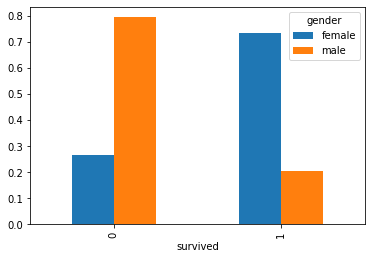

In [ ]:
cond_survived_gender.plot.bar()

A different way to visualize a conditional distribution is to use a stacked bar graph. Here, we want one bar for females and another for males, each one divided in proportion to the survival rates for that gender. First, let's take a look at the desired graph.

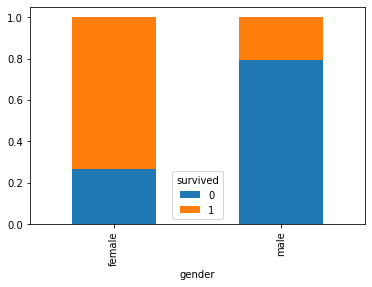

In [ ]:
cond_survived_gender.T.plot.bar(stacked=True)

Now, let's unpack the code that generated this graphic. Recall that `.plot.bar()` plots each column of a `DataFrame` in a different color. Here we want different colors for each level of **survived**, so we need to swap the rows and columns of `cond_survived_gender`. In other words, we need the _transpose_ of the `DataFrame`, which is accomplished using `.T`.

In [ ]:
cond_survived_gender.T

survived,0,1
gender,,
female,0.265849,0.734151
male,0.795111,0.204889


When we call `.plot.bar()` on this transposed `DataFrame`, with `stacked=True`, we obtain the stacked bar graph above.

## Exercises

Exercises 1-4 ask you to continue working with the Titanic data set explored in this lesson.

1\. Filter the data to include passengers only. Calculate the joint distribution between a passenger's class and where they embarked. 

In [ ]:
def class_to_type(c):
  if c in ["1st", "2nd", "3rd"]:
    return "passenger"
  else:
    return "crew"

df_titanic["type"] = df_titanic["class"].map(class_to_type)
df_passengers = df_titanic[df_titanic["type"] == "passenger"]
joint_class_embarked = pd.crosstab(df_passengers["embarked"], df_passengers["class"], normalize=True)
joint_class_embarked

class,1st,2nd,3rd
embarked,,,
B,0.002278,0.004556,0.000000
C,0.108580,0.019742,0.077449
Q,0.002278,0.005315,0.085801
S,0.132878,0.186029,0.375095


2\. Using the joint distribution that you calculated in Exercise 1, calculate the following:

- the conditional distribution of their class given where they embarked
- the conditional distribution of where they embarked given their class

Use the conditional distributions that you calculate to answer the following questions:

- What proportion of 3rd class passengers embarked at Southampton?
- What proportion of Southampton passengers were in 3rd class?

In [ ]:
embarked = joint_class_embarked.sum(axis=1)
cond_class_embarked = joint_class_embarked.divide(embarked, axis=0)
cond_class_embarked

given_class = joint_class_embarked.sum(axis=0)
cond_embarked_class = joint_class_embarked.divide(given_class, axis=1)
cond_embarked_class

class,1st,2nd,3rd
embarked,,,
B,0.333333,0.666667,0.000000
C,0.527675,0.095941,0.376384
Q,0.024390,0.056911,0.918699
S,0.191466,0.268053,0.540481


**0.5405 of 3rd class passengers embarked at Southamption. 0.6968 of Southampton passengers were in 3rd class.**

3\. Make a visualization showing the distribution of a passenger's class, given where they embarked.

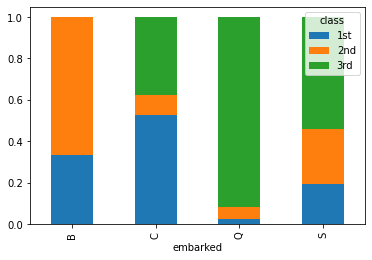

In [ ]:
cond_class_embarked.plot.bar(stacked=True)

4\. Compare the survival rates of crew members versus passengers. Which group appears to survive at higher rates?

(_Hint:_ You will have to transform the **class** variable to a variable that indicates whether a person was a passenger or a crew member. Refer to the previous lesson.)

In [ ]:
joint_survived_type = pd.crosstab(df_titanic["survived"], df_titanic["type"], normalize=True)
joint_survived_type

type_marginal = joint_survived_type.sum(axis=0)
survived_given_type = joint_survived_type.divide(type_marginal, axis=1)
survived_given_type

type,crew,passenger
survived,,
0,0.762921,0.620349
1,0.237079,0.379651


**Passengers appear to survive at higher rates.**

Exercises 5-6 ask you to work with the Florida Death Penalty data set, which is available at  https://dlsun.github.io/pods/data/death_penalty.csv. This data set contains information about the races of the defendant and the victim, as well as whether a death penalty verdict was rendered, in 674 homicide trials in Florida between 1976-1987.

5\. Use the joint distribution to summarize the relationship between the defendant's and the victim's races in Florida homicides.

In [4]:
df_dp = pd.read_csv(data_dir + "death_penalty.csv")
joint_race = pd.crosstab(df_dp["Defendant's Race"], df_dp["Victim's Race"], normalize=True)
joint_race

Victim's Race,Black,White
Defendant's Race,,
Black,0.212166,0.071217
White,0.023739,0.692878


6\. Does there appear to be a relationship between death penalty verdicts and the defendant's race? If so, in what direction?

In [8]:
joint_defendant_death = pd.crosstab(df_dp["Defendant's Race"], df_dp["Death Penalty"], normalize=True)
joint_defendant_death

Death Penalty,No,Yes
Defendant's Race,,
Black,0.261128,0.022255
White,0.637982,0.078635


In [10]:
dp_given_defendant = joint_defendant_death.divide(joint_defendant_death.sum(axis=1), axis=0)
dp_given_defendant

Death Penalty,No,Yes
Defendant's Race,,
Black,0.921466,0.078534
White,0.890269,0.109731


The above cell gives P(penalty | defendant's race).

**Given that the defendant's race is White, the Death Penalty verdict is more likely to be Yes. Therefore, there appears to be a relationship between death penalty verdicts and the defendant's race.**

